In [7]:
import ast
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

**Load annotations and results**

In [8]:
# Relevant paths
train_results_file = (
    "../dataset/results/model=slow_r50-w-negatives_e=100_split=train.pkl"
)
val_results_file = "../dataset/results/model=slow_r50-w-negatives_e=100_split=val.pkl"


model_name = "slow_r50-w-negatives"
folder_path = "../dataset/results/"
metadata_file = "../dataset/metadata/metadata.csv"
behavioural_labels_file = "../dataset/metadata/behaviours.txt"
segements_file = "../dataset/metadata/segements.txt"

In [9]:
with open(
    train_results_file,
    "rb",
) as f:
    train_data = pkl.load(f)

with open(val_results_file, "rb") as f:
    val_data = pkl.load(f)

metadata_df = pd.read_csv(metadata_file)

with open(behavioural_labels_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segements_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

In [10]:
def results2df(train_data, val_data, metadata_df):
    # Process subclips
    subclips = []
    for i, split in enumerate([train_data, val_data]):
        for name, pred, feat, label in zip(
            split["names"], split["preds"], split["feats"], split["labels"]
        ):
            subclips.append(
                {
                    "name": name,
                    "split": i,
                    "pred": pred,
                    "feat": feat,
                    "negative": True if sum(label) == 0 else False,
                }
            )

    df = pd.DataFrame(subclips, columns=["name", "split", "pred", "feat", "negative"])

    df["split"] = df.split.map({0: "train", 1: "val"})
    df = df.merge(metadata_df, how="left", left_on="name", right_on="subject_id")

    # Apply sigmoid to predictions
    df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))

    # Convert label from str to int
    df.label = df.label.apply(lambda x: np.array(ast.literal_eval(x)))

    # Add negative
    df["negative"] = df.label.apply(lambda x: sum(x) == 0)

    # Add global location count to dataframe
    df["location_count"] = df.utm.map(df.utm.value_counts())

    # Return train and val dataframes
    train_df = df[df.split == "train"]
    val_df = df[df.split == "val"]

    return train_df, val_df


def print_per_segement_performance(map, segment, show_per_class=False):
    res = []
    for i, (b, s) in enumerate(zip(map, segments)):
        if s == segment:
            res.append({behaviours[i]: b})
    agg_values = []
    for r in res:
        for _, value in r.items():
            agg_values.append(value)
    if show_per_class:
        print(f"{segment}: {np.mean(agg_values):.2f} {res}")
    else:
        print(f"{segment}: {np.mean(agg_values):.2f}")

In [11]:
# This will return dfs with preds, feats, labels, and all metadata
train_df, val_df = results2df(train_data, val_data, metadata_df)

In [12]:
def return_ct_location_segments(df, head=50, tail=10):
    """
    Returns the location segments based on the given dataframe and thresholds.

    Args:
        df (pandas.DataFrame): The input dataframe containing the location data.
        head (int, optional): The threshold percentage for selecting locations that make up the top percentage of data. Defaults to 50.
        tail (int, optional): The threshold count for selecting locations outside the top percentage with more than this count. Defaults to 10.

    Returns:
        tuple: A tuple containing three dataframes:
            - head_locations: Dataframe containing the top locations and their video counts.
            - tail_locations: Dataframe containing the locations outside the top percentage with more than the tail count.
            - few_shot_locations: Dataframe containing the locations with fewer than the tail count.
    """
    # Group by 'utm' and count the number of videos for each location
    location_counts = train_df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )

    # Select locations that make up 50% of the data
    head_locations = location_counts[location_counts["cumulative_percentage"] <= head]

    # Calculate locations outside the top 50% with more than 10 samples
    tail_locations = location_counts[location_counts["cumulative_percentage"] > head]
    tail_locations = tail_locations[tail_locations["video_count"] > tail]

    # Calculate locations with fewer than 10 samples
    few_shot_locations = location_counts[location_counts["video_count"] < tail]

    return (
        head_locations[["utm", "video_count"]],
        tail_locations[["utm", "video_count"]],
        few_shot_locations[["utm", "video_count"]],
    )


def plot_camera_locations_distribution(df, head=50, tail=10, use_proportion=False):
    # Group by 'utm' and count the number of videos for each location
    location_counts = df["utm"].value_counts().reset_index()
    location_counts.columns = ["utm", "video_count"]

    # Calculate the total number of videos
    total_videos = location_counts["video_count"].sum()

    # Sort locations by video count in descending order and calculate cumulative sum and percentage
    location_counts = location_counts.sort_values("video_count", ascending=False)
    location_counts["cumulative_count"] = location_counts["video_count"].cumsum()
    location_counts["cumulative_percentage"] = (
        location_counts["cumulative_count"] / total_videos * 100
    )

    # Identify the indices for head (50%), tail (>10), and few-shot (<10) segments
    head_index = location_counts[
        location_counts["cumulative_percentage"] <= head
    ].index[-1]
    tail_index = location_counts[location_counts["video_count"] > tail].index[-1]

    # Determine y-axis values based on use_proportion
    y_values = (
        location_counts["cumulative_percentage"]
        if use_proportion
        else location_counts["cumulative_count"]
    )
    y_label = (
        "Cumulative Proportion of Videos"
        if use_proportion
        else "Cumulative Number of Videos"
    )
    y_max = 100 if use_proportion else total_videos

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(location_counts)), y_values, "b-")

    # Add vertical lines and annotations for segments
    plt.axvline(x=head_index, color="r", linestyle="--", label="Head (50%)")
    plt.axvline(x=tail_index, color="g", linestyle="--", label="Tail (>10 samples)")

    # Fill areas for each segment
    plt.fill_between(
        range(head_index + 1),
        y_values[: head_index + 1],
        alpha=0.3,
        color="r",
        label="Head",
    )
    plt.fill_between(
        range(head_index + 1, tail_index + 1),
        y_values[head_index + 1 : tail_index + 1],
        alpha=0.3,
        color="g",
        label="Tail",
    )
    plt.fill_between(
        range(tail_index + 1, len(location_counts)),
        y_values[tail_index + 1 :],
        alpha=0.3,
        color="y",
        label="Few-shot",
    )

    # Customize the plot
    plt.title("Cumulative Distribution of Videos Across Camera Locations")
    plt.xlabel("Camera Locations (sorted by video count)")
    plt.ylabel(y_label)
    plt.legend()

    # Add text annotations
    plt.text(
        head_index,
        y_max / 2,
        f"Head: {head_index+1} locations",
        rotation=90,
        verticalalignment="center",
    )
    plt.text(
        tail_index,
        y_max / 2,
        f"Tail: {tail_index-head_index} locations",
        rotation=90,
        verticalalignment="center",
    )
    plt.text(
        len(location_counts) - 1,
        y_max / 2,
        f"Few-shot: {len(location_counts)-tail_index-1} locations",
        rotation=90,
        verticalalignment="center",
    )

    plt.ylim(0, y_max)
    plt.show()

In [13]:
# Do this to inspect camera location segments
h_df, t_df, f_df = return_ct_location_segments(train_df, head=50, tail=10)

# Merge with original dataframe
h_df = h_df.merge(train_df, on="utm", how="left")
t_df = t_df.merge(train_df, on="utm", how="left")
f_df = f_df.merge(train_df, on="utm", how="left")

In [17]:
train_df

,name,split,pred,feat,negative,subject_id,country,research_site,location_metadata,habitat,...,time_hr,time_min,age_sex_group,site,longitude,latitude,utm,value,label,location_count
0,acp0000ecx.mp4,train,"[tensor(6.3176e-05), tensor(0.0004), tensor(9....","[0.202618, 0.112412855, 0.20876047, 0.14524873...",True,acp0000ecx.mp4,drc,bili,trail,"forest - mixed, open understorey",...,16.0,23.0,juvenile unclear,bili,240967,477386,0240967_0477386,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12
1,acp0000ecz.mp4,train,"[tensor(5.6776e-05), tensor(0.0004), tensor(0....","[0.18562122, 0.09910525, 0.21377066, 0.1509504...",True,acp0000ecz.mp4,drc,bili,trail,"forest - mixed, open understorey",...,16.0,23.0,juvenile unclear,bili,240967,477386,0240967_0477386,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12
2,acp0000ed2.mp4,train,"[tensor(4.9960e-05), tensor(0.0002), tensor(8....","[0.24130227, 0.13679485, 0.21724322, 0.0991669...",True,acp0000ed2.mp4,drc,bili,trail,"forest - mixed, open understorey",...,16.0,23.0,juvenile unclear,bili,240967,477386,0240967_0477386,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12
3,acp0000ee5.mp4,train,"[tensor(2.8033e-06), tensor(8.3216e-07), tenso...","[0.12352447, 1.0829376, 0.91760814, 0.01158339...",False,acp0000ee5.mp4,drc,bili,trail,"forest - mixed, open understorey",...,14.0,6.0,adolescent male,bili,240967,477386,0240967_0477386,camera_reaction,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12
4,acp0000ee8.mp4,train,"[tensor(1.0173e-05), tensor(2.1229e-05), tenso...","[0.32694876, 0.3323945, 0.10662508, 0.23873402...",True,acp0000ee8.mp4,drc,bili,trail,"forest - mixed, open understorey",...,14.0,6.0,adolescent male,bili,240967,477386,0240967_0477386,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,acp0003nfz.mp4,train,"[tensor(8.4871e-05), tensor(1.2909e-06), tenso...","[0.033863522, 0.6149759, 0.16937792, 0.2997537...",False,acp0003nfz.mp4,cotedivoire,tair,under canopy/liana,"forest - mixed, open understorey",...,8.0,1.0,adolescent female,tair,686423,651087,0686423_0651087,travel,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",8
2274,acp0003nwk.mp4,train,"[tensor(0.0001), tensor(0.0006), tensor(0.9720...","[0.028156085, 0.15293917, 0.33212194, 0.005337...",False,acp0003nwk.mp4,cotedivoire,tair,under canopy/liana,"forest - mixed, open understorey",...,17.0,0.0,adult male,tair,686423,651087,0686423_0651087,"camera_reaction,resting,travel","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]",8
2275,acp0003nwm.mp4,train,"[tensor(0.0015), tensor(0.0008), tensor(0.1804...","[0.08315775, 0.22064902, 0.24458064, 0.0094131...",True,acp0003nwm.mp4,cotedivoire,tair,under canopy/liana,"forest - mixed, open understorey",...,17.0,0.0,adult male,tair,686423,651087,0686423_0651087,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",8
2276,acp0004g4t.mp4,train,"[tensor(0.0044), tensor(0.0069), tensor(0.0032...","[0.11014623, 0.13159546, 0.17685264, 0.4972862...",False,acp0004g4t.mp4,cotedivoire,tair,beehive,"forest - mixed, open understorey",...,7.0,24.0,juvenile unclear,tair,687487,648569,0687487_0648569,travel,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",8


In [16]:
h_df

,utm,video_count,name,split,pred,feat,negative,subject_id,country,research_site,...,year,time_hr,time_min,age_sex_group,site,longitude,latitude,value,label,location_count
0,0336939_0191998,146,acp000b754.mp4,train,"[tensor(1.0365e-05), tensor(5.6692e-05), tenso...","[0.09164363, 0.16989769, 0.42098492, 1.5070953...",True,acp000b754.mp4,uganda,budongo,...,2012.0,6.0,51.0,adult male,budongo,336939,191998,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",175
1,0336939_0191998,146,acp000b757.mp4,train,"[tensor(2.6531e-05), tensor(0.0002), tensor(9....","[0.08623659, 0.17142616, 0.36669776, 1.3958143...",True,acp000b757.mp4,uganda,budongo,...,2012.0,6.0,51.0,adult male,budongo,336939,191998,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",175
2,0336939_0191998,146,acp000b759.mp4,train,"[tensor(1.5468e-05), tensor(9.6222e-05), tenso...","[0.07437469, 0.17244603, 0.4240141, 1.4805675,...",True,acp000b759.mp4,uganda,budongo,...,2012.0,6.0,51.0,adult male,budongo,336939,191998,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",175
3,0336939_0191998,146,acp000b7cj.mp4,train,"[tensor(0.0001), tensor(0.0199), tensor(0.0046...","[0.06902052, 0.36060217, 0.18340723, 0.3061357...",True,acp000b7cj.mp4,uganda,budongo,...,2012.0,16.0,50.0,adult male,budongo,336939,191998,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",175
4,0336939_0191998,146,acp000b7ck.mp4,train,"[tensor(5.8410e-06), tensor(0.0003), tensor(6....","[0.13100477, 0.41091877, 0.26175246, 0.3143814...",True,acp000b7ck.mp4,uganda,budongo,...,2012.0,16.0,50.0,adult male,budongo,336939,191998,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,0336740_0191880,26,acp000bbr1.mp4,train,"[tensor(1.1857e-05), tensor(2.4489e-05), tenso...","[0.3800378, 0.09230689, 0.015997613, 0.9067278...",False,acp000bbr1.mp4,uganda,budongo,...,2012.0,15.0,53.0,unidentifiable unclear,budongo,336740,191880,climbing,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",31
1120,0336740_0191880,26,acp000bbr3.mp4,train,"[tensor(1.2855e-05), tensor(9.5451e-06), tenso...","[0.3961034, 0.08415927, 0.012310158, 0.9904467...",True,acp000bbr3.mp4,uganda,budongo,...,2012.0,15.0,53.0,unidentifiable unclear,budongo,336740,191880,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",31
1121,0336740_0191880,26,acp000bbv8.mp4,train,"[tensor(2.2115e-05), tensor(0.0005), tensor(6....","[0.38725445, 0.058540966, 0.038806926, 1.00829...",False,acp000bbv8.mp4,uganda,budongo,...,2012.0,5.0,7.0,juvenile unclear,budongo,336740,191880,climbing,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",31
1122,0336740_0191880,26,acp000bbv9.mp4,train,"[tensor(3.8498e-05), tensor(0.0010), tensor(1....","[0.34472173, 0.055259373, 0.0354362, 0.9515643...",True,acp000bbv9.mp4,uganda,budongo,...,2012.0,5.0,7.0,juvenile unclear,budongo,336740,191880,none,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",31


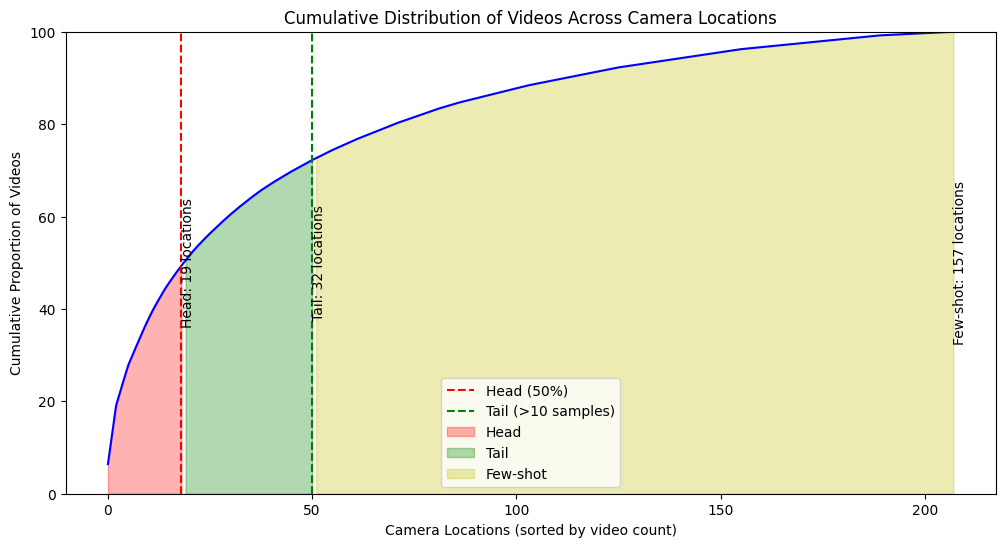

In [14]:
# Usage:
plot_camera_locations_distribution(train_df, head=50, tail=10, use_proportion=True)